In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Loading the data

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist['data'], mnist['target']
X = X.to_numpy()
y = y.to_numpy()

/Users/fedoradushev/anaconda3/envs/tensorflow_new/lib/python3.10/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


# Displaying the data

In [3]:
print('this is the shape: ', '\n', X.shape)
print()
print('these are the labels: ', '\n', y[5: 10])
print()
print('this are some values of a datapoint: ', '\n', X[10, 400:410])

this is the shape:  
 (70000, 784)

these are the labels:  
 ['2' '1' '3' '1' '4']

this are some values of a datapoint:  
 [  0.   0.   0. 110. 246. 254. 254. 254. 254. 254.]


The dataset consists of **70,000 images** of numbers **28*28 pixels**

  pixel intensities range from 0 (Black) to 255 (White)

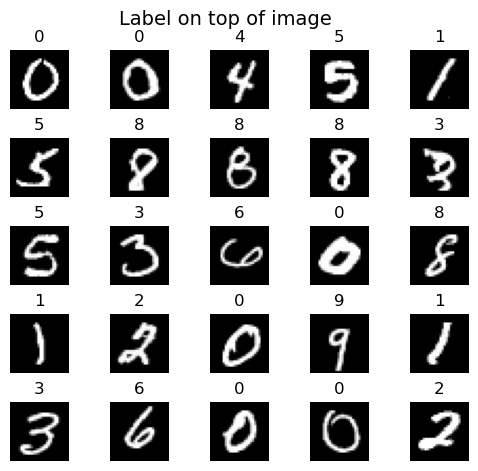

In [4]:
m, n = X.shape

fig, axes = plt.subplots(5,5, figsize=(5,5))       # 'fig': overall fugure (8rows x 8columns with total size of 5x5 inch)  & 'axes': subplots
fig.tight_layout(pad=0.005,rect=[0, 0.03, 1, 0.91]) #[left, bottom, right, top]

#fig.tight_layout(pad=0.5)
for i,ax in enumerate(axes.flat):                  # By passing an iterable object (.flat allows to enumerate through index & subplot)
    # random index for each subplot
    random_index = np.random.randint(m)

    # reshape the random datapoint
    X_random_reshaped = X[random_index].reshape((28,28))

    # display image
    ax.imshow(X_random_reshaped, cmap='gray')

    # label above the image
    ax.set_title(y[random_index])
    ax.set_axis_off()
    fig.suptitle("Label on top of image", fontsize=14)

# Preparing tha data

In [17]:
from sklearn.model_selection import train_test_split

X, y = mnist['data'].values, mnist['target'].values.reshape(-1, 1)

# normalize the data set
X = X.reshape((70000, 28, 28))
X_normalized = X.astype('float32')/255

X_train, X_temp, y_train, y_temp = train_test_split(X_normalized, y, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)


def label_to_np(label):
  label = label.to_numpy()
  label = label.astype(int)
  return label

y_train = label_to_np(y_train).astype('float32')
y_test = label_to_np(y_test).astype('float32')
y_valid = label_to_np(y_valid).astype('float32')

In [18]:
print(X_train.shape)
print(y_train.shape)

(42000, 28, 28)
(42000, 1)


In [32]:
def gelu(x):
    """Gaussian Error Linear Unit.
    This is a smoother version of the RELU.
    Original paper: https://arxiv.org/abs/1606.08415
    refer : https://github.com/google-research/bert/blob/bee6030e31e42a9394ac567da170a89a98d2062f/modeling.py#L264
    Args:
        x: float Tensor to perform activation.
    Returns:
        `x` with the GELU activation applied.
    """
    cdf = 0.5 * (1.0 + tf.tanh(
        (np.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3)))))
    return x * cdf

In [69]:
# swish, mish, selu, gelu 

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def train_model(X_train, y_train, X_valid, y_valid, ACTIVATION, num_conv, large_model, ARCHITECTURE,
               training_times, validation_accuracy, architectures):  

        model = tf.keras.Sequential()

        for _ in range(num_conv):
            model.add(Conv2D(32, 3, activation=ACTIVATION, input_shape=(28, 28, 1)))
            model.add(MaxPooling2D((2, 2)))
        
        model.add(Flatten())

    
        model.add(Dense(8, activation=ACTIVATION))
        model.add(Dropout(0.2))
    
        if large_model:
            model.add(Dense(128, activation=ACTIVATION))
            model.add(Dropout(0.2))
    
        model.add(Dense(10))

    
        model.compile(metrics=['acc'], 
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                       optimizer=tf.keras.optimizers.legacy.Adam())

        import time
        t_start = time.time()
        history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size=32)
        t_end = time.time()
        training_time = t_end - t_start



        # add average of the validation accuracy to a list
        average_accuracy = sum(history.history['val_acc']) / len(history.history['val_acc'])
        validation_accuracy.append(average_accuracy)

        # add training time to a list 
        training_times.append(training_time)

        # teack the architecture
        architectures.append(ARCHITECTURE)
    
        return validation_accuracy, training_times, architectures



In [178]:
# lists for tracking the training time & validation accuracy
training_times = list()
validation_accuracy = list()
architectures = list()

In [73]:
validation_accuracy, training_times, architectures = train_model(X_train, y_train, X_valid, y_valid, ACTIVATION='relu', num_conv=0, large_model=False, ARCHITECTURE='CONV=0 | SM | relu',
                                                               training_times=training_times, validation_accuracy=validation_accuracy, architectures=architectures)
validation_accuracy, training_times, architectures = train_model(X_train, y_train, X_valid, y_valid, ACTIVATION='relu', num_conv=0, large_model=True, ARCHITECTURE='CONV=0 | LM | relu',
                                                               training_times=training_times, validation_accuracy=validation_accuracy, architectures=architectures)
validation_accuracy, training_times, architectures = train_model(X_train, y_train, X_valid, y_valid, ACTIVATION='relu', num_conv=1, large_model=False, ARCHITECTURE='CONV=1 | SM | relu',
                                                               training_times=training_times, validation_accuracy=validation_accuracy, architectures=architectures)
validation_accuracy, training_times, architectures = train_model(X_train, y_train, X_valid, y_valid, ACTIVATION='relu', num_conv=1, large_model=True, ARCHITECTURE='CONV=1 | LM | relu',
                                                               training_times=training_times, validation_accuracy=validation_accuracy, architectures=architectures)
validation_accuracy, training_times, architectures = train_model(X_train, y_train, X_valid, y_valid, ACTIVATION='relu', num_conv=2, large_model=False, ARCHITECTURE='CONV=2 | SM | relu',
                                                               training_times=training_times, validation_accuracy=validation_accuracy, architectures=architectures)
validation_accuracy, training_times, architectures = train_model(X_train, y_train, X_valid, y_valid, ACTIVATION='relu', num_conv=2, large_model=True, ARCHITECTURE='CONV=2 | LM | relu',
                                                               training_times=training_times, validation_accuracy=validation_accuracy, architectures=architectures)
print('training relu models done')

validation_accuracy, training_times, architectures = train_model(X_train, y_train, X_valid, y_valid, ACTIVATION='swish', num_conv=0, large_model=False, ARCHITECTURE='CONV=0 | SM | swish',
                                                               training_times=training_times, validation_accuracy=validation_accuracy, architectures=architectures)
validation_accuracy, training_times, architectures = train_model(X_train, y_train, X_valid, y_valid, ACTIVATION='swish', num_conv=0, large_model=True, ARCHITECTURE='CONV=0 | LM | swish',
                                                               training_times=training_times, validation_accuracy=validation_accuracy, architectures=architectures)
validation_accuracy, training_times, architectures = train_model(X_train, y_train, X_valid, y_valid, ACTIVATION='swish', num_conv=1, large_model=False, ARCHITECTURE='CONV=1 | SM | swish',
                                                               training_times=training_times, validation_accuracy=validation_accuracy, architectures=architectures)
validation_accuracy, training_times, architectures = train_model(X_train, y_train, X_valid, y_valid, ACTIVATION='swish', num_conv=1, large_model=True, ARCHITECTURE='CONV=1 | LM | swish',
                                                               training_times=training_times, validation_accuracy=validation_accuracy, architectures=architectures)
validation_accuracy, training_times, architectures = train_model(X_train, y_train, X_valid, y_valid, ACTIVATION='swish', num_conv=2, large_model=False, ARCHITECTURE='CONV=2 | SM | swish',
                                                               training_times=training_times, validation_accuracy=validation_accuracy, architectures=architectures)
validation_accuracy, training_times, architectures = train_model(X_train, y_train, X_valid, y_valid, ACTIVATION='swish', num_conv=2, large_model=True, ARCHITECTURE='CONV=2 | LM | swish',
                                                               training_times=training_times, validation_accuracy=validation_accuracy, architectures=architectures)
print('training swish models done')

validation_accuracy, training_times, architectures = train_model(X_train, y_train, X_valid, y_valid, ACTIVATION='mish', num_conv=0, large_model=False, ARCHITECTURE='CONV=0 | SM | mish',
                                                               training_times=training_times, validation_accuracy=validation_accuracy, architectures=architectures)
validation_accuracy, training_times, architectures = train_model(X_train, y_train, X_valid, y_valid, ACTIVATION='mish', num_conv=0, large_model=True, ARCHITECTURE='CONV=0 | LM | mish',
                                                               training_times=training_times, validation_accuracy=validation_accuracy, architectures=architectures)
validation_accuracy, training_times, architectures = train_model(X_train, y_train, X_valid, y_valid, ACTIVATION='mish', num_conv=1, large_model=False, ARCHITECTURE='CONV=1 | SM | mish',
                                                               training_times=training_times, validation_accuracy=validation_accuracy, architectures=architectures)
validation_accuracy, training_times, architectures = train_model(X_train, y_train, X_valid, y_valid, ACTIVATION='mish', num_conv=1, large_model=True, ARCHITECTURE='CONV=1 | LM | mish',
                                                               training_times=training_times, validation_accuracy=validation_accuracy, architectures=architectures)
validation_accuracy, training_times, architectures = train_model(X_train, y_train, X_valid, y_valid, ACTIVATION='mish', num_conv=2, large_model=False, ARCHITECTURE='CONV=2 | SM | mish',
                                                               training_times=training_times, validation_accuracy=validation_accuracy, architectures=architectures)
validation_accuracy, training_times, architectures = train_model(X_train, y_train, X_valid, y_valid, ACTIVATION='mish', num_conv=2, large_model=True, ARCHITECTURE='CONV=2 | LM | mish',
                                                               training_times=training_times, validation_accuracy=validation_accuracy, architectures=architectures)
print('training mish models done')

validation_accuracy, training_times, architectures = train_model(X_train, y_train, X_valid, y_valid, ACTIVATION='selu', num_conv=0, large_model=False, ARCHITECTURE='CONV=0 | SM | selu',
                                                               training_times=training_times, validation_accuracy=validation_accuracy, architectures=architectures)
validation_accuracy, training_times, architectures = train_model(X_train, y_train, X_valid, y_valid, ACTIVATION='selu', num_conv=0, large_model=True, ARCHITECTURE='CONV=0 | LM | selu',
                                                               training_times=training_times, validation_accuracy=validation_accuracy, architectures=architectures)
validation_accuracy, training_times, architectures = train_model(X_train, y_train, X_valid, y_valid, ACTIVATION='selu', num_conv=1, large_model=False, ARCHITECTURE='CONV=1 | SM | selu',
                                                               training_times=training_times, validation_accuracy=validation_accuracy, architectures=architectures)
validation_accuracy, training_times, architectures = train_model(X_train, y_train, X_valid, y_valid, ACTIVATION='selu', num_conv=1, large_model=True, ARCHITECTURE='CONV=1 | LM | selu',
                                                               training_times=training_times, validation_accuracy=validation_accuracy, architectures=architectures)
validation_accuracy, training_times, architectures = train_model(X_train, y_train, X_valid, y_valid, ACTIVATION='selu', num_conv=2, large_model=False, ARCHITECTURE='CONV=2 | SM | selu',
                                                               training_times=training_times, validation_accuracy=validation_accuracy, architectures=architectures)
validation_accuracy, training_times, architectures = train_model(X_train, y_train, X_valid, y_valid, ACTIVATION='selu', num_conv=2, large_model=True, ARCHITECTURE='CONV=2 | LM | selu',
                                                               training_times=training_times, validation_accuracy=validation_accuracy, architectures=architectures)
print('training selu models done')

validation_accuracy, training_times, architectures = train_model(X_train, y_train, X_valid, y_valid, ACTIVATION=gelu, num_conv=0, large_model=False, ARCHITECTURE='CONV=0 | SM | gelu',
                                                               training_times=training_times, validation_accuracy=validation_accuracy, architectures=architectures)
validation_accuracy, training_times, architectures = train_model(X_train, y_train, X_valid, y_valid, ACTIVATION=gelu, num_conv=0, large_model=True, ARCHITECTURE='CONV=0 | LM | gelu',
                                                               training_times=training_times, validation_accuracy=validation_accuracy, architectures=architectures)
validation_accuracy, training_times, architectures = train_model(X_train, y_train, X_valid, y_valid, ACTIVATION=gelu, num_conv=1, large_model=False, ARCHITECTURE='CONV=1 | SM | gelu',
                                                               training_times=training_times, validation_accuracy=validation_accuracy, architectures=architectures)
validation_accuracy, training_times, architectures = train_model(X_train, y_train, X_valid, y_valid, ACTIVATION=gelu, num_conv=1, large_model=True, ARCHITECTURE='CONV=1 | LM | gelu',
                                                               training_times=training_times, validation_accuracy=validation_accuracy, architectures=architectures)
validation_accuracy, training_times, architectures = train_model(X_train, y_train, X_valid, y_valid, ACTIVATION=gelu, num_conv=2, large_model=False, ARCHITECTURE='CONV=2 | SM | gelu',
                                                               training_times=training_times, validation_accuracy=validation_accuracy, architectures=architectures)
validation_accuracy, training_times, architectures = train_model(X_train, y_train, X_valid, y_valid, ACTIVATION=gelu, num_conv=2, large_model=True, ARCHITECTURE='CONV=2 | LM | gelu',
                                                               training_times=training_times, validation_accuracy=validation_accuracy, architectures=architectures)
print('training gelu models done')

Epoch 1/10
1313/1313 [==============================] - 8s 6ms/step - loss: 0.4206 - acc: 0.8785 - val_loss: 0.3155 - val_acc: 0.9127
Epoch 2/10
1313/1313 [==============================] - 7s 6ms/step - loss: 0.3555 - acc: 0.9029 - val_loss: 0.3143 - val_acc: 0.9127
Epoch 3/10
1313/1313 [==============================] - 7s 5ms/step - loss: 0.3584 - acc: 0.9017 - val_loss: 0.3232 - val_acc: 0.9122
Epoch 4/10
1313/1313 [==============================] - 7s 6ms/step - loss: 0.3674 - acc: 0.8991 - val_loss: 0.3287 - val_acc: 0.9141
Epoch 5/10
1313/1313 [==============================] - 7s 5ms/step - loss: 0.3756 - acc: 0.8980 - val_loss: 0.3304 - val_acc: 0.9155
Epoch 6/10
1313/1313 [==============================] - 7s 5ms/step - loss: 0.3846 - acc: 0.8970 - val_loss: 0.3320 - val_acc: 0.9129
Epoch 7/10
1313/1313 [==============================] - 7s 5ms/step - loss: 0.3966 - acc: 0.8958 - val_loss: 0.3564 - val_acc: 0.9073
Epoch 8/10
1313/1313 [==============================] - 7s 5ms

In [170]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def train_model(X_train, y_train, X_valid, y_valid, ACTIVATION, num_conv, large_model, ARCHITECTURE,
               training_times, validation_accuracy, architectures):  

        model = tf.keras.Sequential()

        for _ in range(num_conv):
            model.add(Conv2D(32, 3, activation=ACTIVATION, input_shape=(28, 28, 1)))
            model.add(MaxPooling2D((2, 2)))
        
        model.add(Flatten())

    
        model.add(Dense(8, activation=ACTIVATION))        #
        model.add(Dropout(0.2))
    
        if large_model:
            model.add(Dense(128, activation=ACTIVATION))      #
            model.add(Dropout(0.2))
    
        model.add(Dense(10))

    
        model.compile(metrics=['acc'], 
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                       optimizer=tf.keras.optimizers.legacy.Adam())

        import time
        t_start = time.time()
        history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size=32)
        t_end = time.time()
        training_time = t_end - t_start



        # add average of the validation accuracy to a list
        average_accuracy = sum(history.history['val_acc']) / len(history.history['val_acc'])
        validation_accuracy.append(average_accuracy)

        # add training time to a list 
        training_times.append(training_time)

        # teack the architecture
        architectures.append(ARCHITECTURE)
    
        return validation_accuracy, training_times, architectures


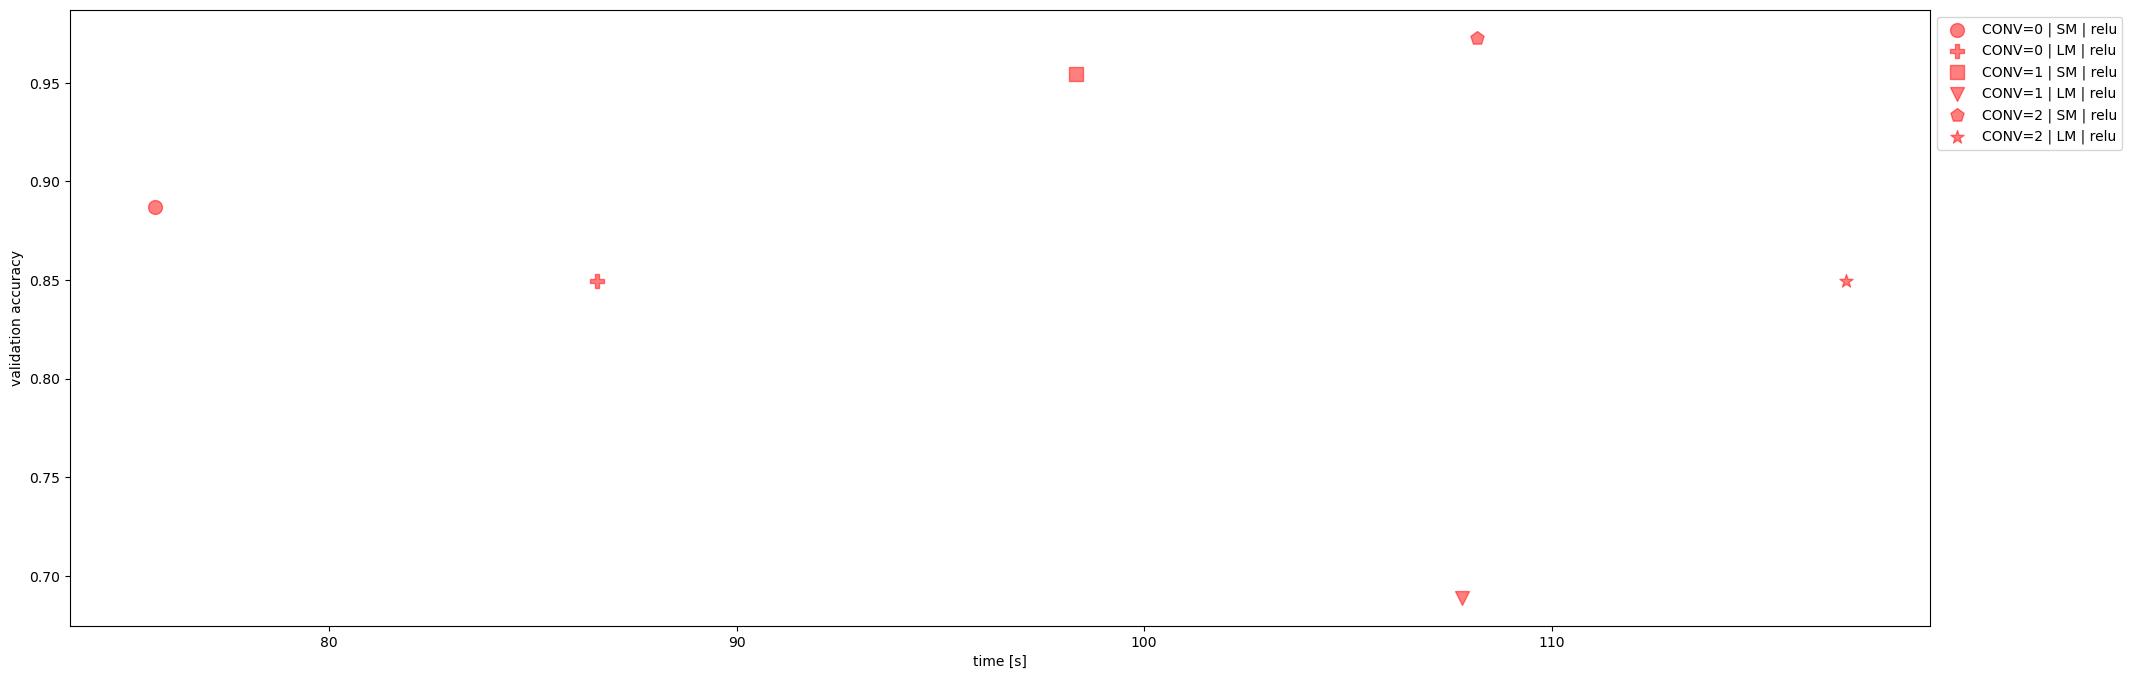

In [177]:
# Create a figure and an axes
fig, ax = plt.subplots(figsize=(24, 8))

markers = ['o', 'P', 's', 'v', 'p', '*']

for i in range(6):
    ax.scatter(training_times[i], validation_accuracy[i], c='red', label=architectures[i], alpha=0.5, marker=markers[i], s=100)


# Add legend outside the plot
legend = ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Add axis labels
ax.set_xlabel('time [s]')
ax.set_ylabel('validation accuracy')

plt.show()


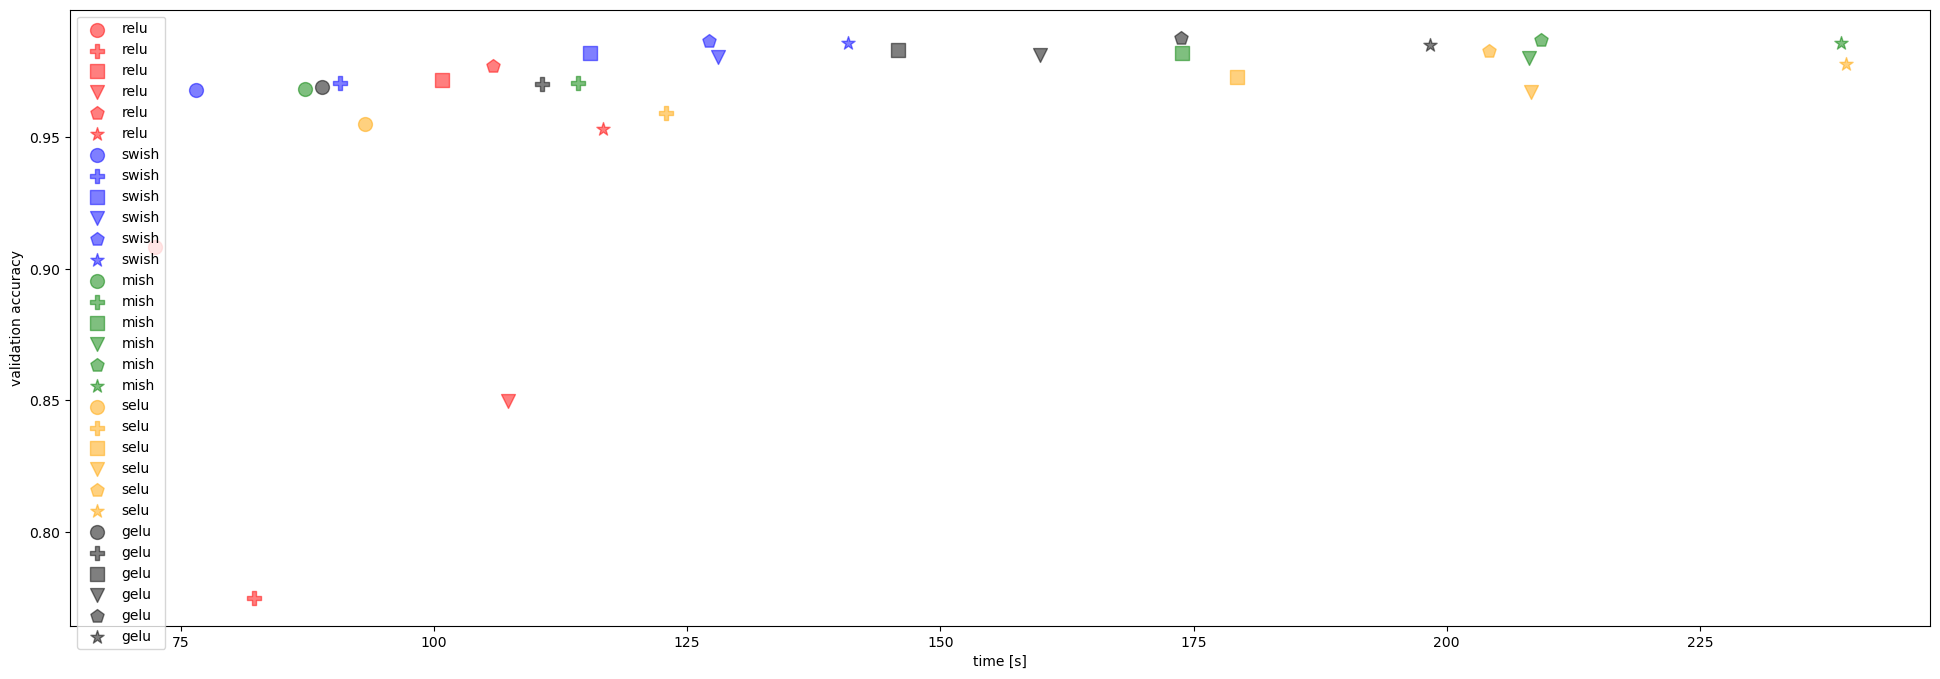

In [143]:
#swish, mish, selu, gelu 
classes = ['red', 'red', 'red', 'red', 'red', 'red', 
           'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 
           'green', 'green', 'green', 'green', 'green', 'green', 
           'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 
           'black', 'black', 'black', 'black', 'black', 'black']

#Create a figure and an axes
fig, ax = plt.subplots(figsize=(24, 8))

markers = ['o', 'P', 's', 'v', 'p', '*']

for i in range(6):
    plt.scatter(training_times[i], validation_accuracy[i], c='red', label=architectures[i], alpha=0.5, marker=markers[i], s=100)
for i in range(6):
    plt.scatter(training_times[i+6], validation_accuracy[i+6], c='blue', label=architectures[i+6], alpha=0.5, marker=markers[i], s=100)
for i in range(6):
    plt.scatter(training_times[i+12], validation_accuracy[i+12], c='green', label=architectures[i+12], alpha=0.5, marker=markers[i], s=100)
for i in range(6):
    plt.scatter(training_times[i+18], validation_accuracy[i+18], c='orange', label=architectures[i+18], alpha=0.5, marker=markers[i], s=100)
for i in range(6):
    plt.scatter(training_times[i+24], validation_accuracy[i+24], c='black', label=architectures[i+24], alpha=0.5, marker=markers[i], s=100)


# Add legend outside the plot
legend = ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Add axis labels
ax.set_xlabel('time [s]')
ax.set_ylabel('Validation Accuracy')

plt.show()